In [157]:
import pandas as pd
import csv
import os
import numpy
import copy
%matplotlib inline
import numpy as np
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim import corpora, models, similarities, matutils
from gensim.corpora.dictionary import Dictionary
from sklearn.cluster import DBSCAN
from sklearn.decomposition import NMF, PCA
import matplotlib as mpl
import matplotlib.pyplot as plt

In [158]:
import matplotlib.pyplot as plt

#Some nice plotting params
mpl.rcParams['figure.figsize'] = (8,5)
mpl.rcParams['lines.linewidth'] = 3
plt.style.use('ggplot')

# Load ISIS data set and clean tweets

In [159]:
df = pd.read_csv('/media/patrick/MY_EXTERNAL/ISIS/tweets.csv', parse_dates= [6])

In [160]:
def clean_tweet(tweet):
    ext = "http"
    text = tweet[:tweet.find(ext)].lower()
    text = re.sub("[^\S]", " ", text)
    text = re.sub("english translation ", "", text)
    textOnly = re.sub("[^a-zA-Z0-9@# ]", "", text)
    return(textOnly)

In [161]:
df.tweets = df.tweets.apply(clean_tweet)

In [162]:
docs = []
for username in df.username.unique():
    words = ''
    for tweet in df[df.username == username].tweets:
        words = words + ' ' + tweet
    docs.append(words)

### Treat all the tweets from one user as a single document and vectorize

In [163]:
Tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                  ngram_range=(1,3), stop_words='english',
                                  token_pattern='\\b[a-z][a-z]+\\b')
tfidf_tweets = Tfidf_vectorizer.fit_transform(docs)

In [164]:
count_vectorizer = CountVectorizer(analyzer='word',
                                  ngram_range=(1,3), stop_words='english',
                                  token_pattern='\\b[a-z][a-z]+\\b')
cv_tweets = count_vectorizer.fit_transform(docs)

--------------------------------------------------------------------------

In [165]:
from sklearn.utils.extmath import randomized_svd
U, Sigma, VT = randomized_svd(cv_tweets, n_components=15,
                                      n_iter=5,
                                      random_state=None)

In [166]:
sigma = []
for k,v in enumerate(Sigma):
    sigma.append((k,v))

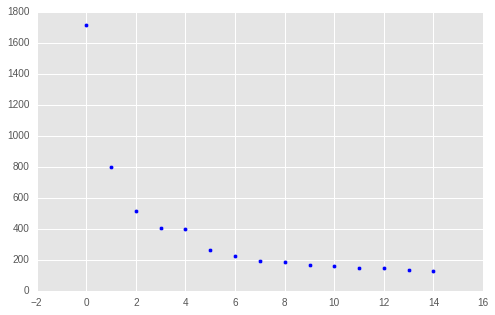

In [167]:
f = plt.scatter(*zip(*sigma))

Based on the sigma values from the resulting matrix we can choose a about 5 components to use in our NMF model in order to explain the most.....?

### NMF decomposition

In [168]:
from collections import Counter, defaultdict

import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

In [169]:
num_topics = 5
model = NMF(n_components=num_topics, init='random', random_state=0)
nmf = model.fit_transform(tfidf_tweets.toarray())

In [170]:
doc_cluster = [list(r).index(max(r)) for r in nmf]

In [171]:
print (doc_cluster[0:20])
print (doc_cluster[41:60])
print (doc_cluster[61:80])
print( doc_cluster[-40:-20])

[2, 1, 4, 4, 2, 4, 2, 4, 4, 1, 2, 0, 4, 4, 0, 2, 1, 4, 4, 4]
[3, 0, 0, 2, 3, 4, 4, 4, 2, 0, 0, 4, 2, 4, 0, 2, 2, 2, 2]
[4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 2, 4, 2, 0, 4, 4, 4, 2]
[2, 4, 2, 0, 4, 4, 4, 2, 2, 4, 2, 0, 2, 2, 1, 2, 2, 4, 2, 4]


In [172]:
cluster_size = [0,0,0,0,0]
for v in doc_cluster:
    cluster_size[v]+=1
cluster_size

[20, 11, 26, 6, 49]

In [173]:
docs[2]

' salamu alaykum im back do supports and spread my new account barakallahu feekum  @yazeeddhardaa25 cc @ibnnuhas @jazrawiuod @striv3ride @afroqaqaisbac @baqiya58 jazakallahu akh @umulbanat1 jazakallahu uk @aljabarti22 jazakallahu ak @ummaysha20 jazakallahu ukhti @abtigood @asadalkanadi1 @bintrose33 jazakallahu ukhti @abuhaleema28 @skxxx50 @abtigood @muslimah1 @jasonphedo @aljabali23 @abdullahkayaniw @checkcontent @skxx51 actually he has been changed drastically after is took a revenged and encircled them in dez @striv3ric @warreports 1 @skxx51 he cant accept the mubahala between sh adnani amp abu abdullah shami where the truth is on is @striv3ric @warreports 2 @skxx51 if all of you remember his tweets from his first acc he used to support is and made a clarification the @striv3ric @warreports3 @skxx51 truth behind jan13 where hes asserted that fsa the one who start the infighting and killing muhajireen @striv3ric @warreports4 @skxx51 those who doesnt know him will says that his tweets 

In [174]:
docs[3]

' best generation ever takbirrr #is #dawlah #cubs  rt @abdelhakzait @nasseralfahad0              ameen #mojahdin #saudi   #is #doma   #    #                  pls share brothers and sisters    #  rt @cnn photo of israeli soldier holding palestinian boy in headlock goes viral  @tawheed1is but one is important to live when the other one is not the word of the week  @ironmuhajir2 @jundhullah14  nothing like jihad god give us the help and power to do our farrid my heart is tears blood every day for those kids from the occupied #syria my loved country  rt @muslimprisoners bothers amp sisters plz show determination if the haters never trier banning abu haleemah we should never stop our sho rt @muslimprisoners mainstream media reporting that @anjemchoudary has 10 bail conditions  thx god our lovely shiekh is free  wish to meet you soon teacher and wish the freedom for all brothers in preson  rt @islamreligion why do muslims eat halal meat         pls re tweet   there is no good in us if the pe

In [175]:
df[df.tweets.str.contains('best geaneration ever takbirrr', na=False)].username

33    abubakerdimshqi
Name: username, dtype: object

In [176]:
df[df.tweets.str.contains('salamu alaykum im back do supports', na=False)].username

31    YazeedDhardaa25
Name: username, dtype: object

In [180]:
cos_sim = cosine_similarity(model.components_,model.components_)

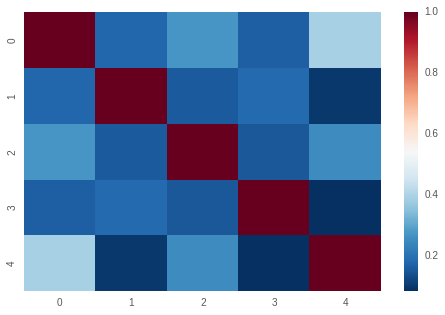

In [182]:
ax_1 = sns.heatmap(cos_sim, cmap="RdBu_r", annot=False)

In [183]:
words = sorted([(i,v) for v,i in Tfidf_vectorizer.vocabulary_.items()])
topic_words = []
for r in model.components_:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:7]
    topic_words.append([words[e[1]] for e in a])

In [184]:
topic_words

[[(116232, 'isis'),
  (199474, 'rt'),
  (233606, 'syria'),
  (129849, 'killed'),
  (25036, 'army'),
  (10744, 'aleppo'),
  (269089, 'ypg')],
 [(17242, 'amaqagency'),
  (120028, 'islamicstate'),
  (42259, 'breaking islamicstate'),
  (41979, 'breaking'),
  (17385, 'amaqagency islamicstate'),
  (120181, 'islamicstate fighters'),
  (86238, 'fighters')],
 [(18556, 'amp'),
  (226724, 'state'),
  (119685, 'islamic state'),
  (119534, 'islamic'),
  (63753, 'dawlah'),
  (13261, 'allah'),
  (133064, 'kronykal')],
 [(51594, 'city'),
  (45802, 'caliphatenew'),
  (45848, 'caliphatenews'),
  (263944, 'wilayatninawa'),
  (120028, 'islamicstate'),
  (263775, 'wilayathalab'),
  (10278, 'albattarengl')],
 [(199474, 'rt'),
  (13261, 'allah'),
  (188211, 'ramiallolah'),
  (204118, 'rt ramiallolah'),
  (18556, 'amp'),
  (116232, 'isis'),
  (174015, 'people')]]

-----

--------

Examples of clergy they like the most: “Anwar Awlaki”, “Ahmad Jibril”, “Ibn Taymiyyah”, “Abdul Wahhab”. Examples of clergy that they hate the most: “Hamza Yusuf”, “Suhaib Webb”, “Yaser Qadhi”, “Nouman Ali Khan”, “Yaqoubi”.

In [20]:
dbscan = DBSCAN(random_state=111)
dbscan

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    min_samples=5, p=None, random_state=111)

In [ ]:
dbscan.labels_

## Creating Graph Edges

#### Currently: 
We have occurences of username strings in all tweets from each user


#### We would like: 
agrregated pairwise co-occurrence of character strings in tweet for each username, Normalized by the sum of all tweet from both usernames being compared.